Aim and outline approach:
Import satellite imagery of Dominica and build an AL Model to identify bridges. Utilise the model pre and post disaster event to rapidly identify bridges that may have been destroyed/damaged and are no longer passable. 

The intention is to utilise imagery data from Dominica's coastline, broken into three representative data sets: Training; Validation; Test. 

We will utilise the highest resolution imagery freely available i.e. Planetscope 3.5m resolution data in RGB and IR and overlay Openstreet Map data to identify river crossings by roads (and other elements such as train tracks/footbridges if time/data allows). We will also investigate the utilisation of elevation/LiDAR data to establish if there is enough resolution to identify bridges through rapid small changes in elevation.
    
    - Set date/time/coordinates
        - Date - 16 September 2017. Imagery should be before then and after 2nd October 2017
        - Time - any without cloud cover during daylight 
        - Coordinates 
            - Dominica 
            - Capital Roseau - 15°18′05″N 61°23′18″W
    - Get imagery
        - Sentinel 2 - 10m too low
        - Planetscope 3.5m might work
    - Get OSM data for bridges and/or roads, rivers, train tracks, footpaths
    - Overlay OSM onto imagery
    - Play around in QGIS 

We will pre-process the data to give the highest resolution of bridges, potentially in identifying areas where some difference in colour/IR/NDVI is present over a body of water. 

    - Play around in QGIS to visually identify most obvious processing that highlights bridges
    - Pre-processing code
        - Overlay imagery 
        - Correction for time of day/angle of the sun etc. 
        - Fancy maths to highlight bridges - Feature engineering?
    - Statistical analysis 

From this and some limited visual inspection we will label the data with bridges.

    - Label data - Is this some sort of bounding box around each bridge at specific coordinates? or just a coordinate of the centre of a bridge?

We will then break the datasets into the three representative datasets, ensuring a broad mix of rural and built up areas, with an average distribution of number of bridges per image over the three sets. 

    - Break data into small sections, say 1km^2
    - Count bridges in each section, quantity of vegetation and buildings
    - Statistical analysis of each section 
        - visualise outputs
    - Create three batches of sections that have the statistically the same number of bridges (average number per image), amount of vegetation and buildings across the batch (or average per image)
    - set batches as training, validation, test

We will then train a YOLO model with the training data set, validate against the validation data set and then test against the test data set.

    - All the standard model training stuff
    - Standard model validation stuff
    - Test model
    - visualise output

After building a working model, we will use this same model to against the same data sets from post Hurricane Maria, to identify differences in the outputs and visual inspection of imagery will be utilised to validate the results. Insights will be used here to revalidate/tune the model.

    - Import new data
    - Process new data
    - Run model
    - Count bridges 
    - Determine difference against reference set
    - Bring out coordinates of differences
    - Overlay differences to new imagery
    - Manually inspect.

Potential issues:
    
    - Bridges may be impassable but not destroyed
    - Bridges may get covered in mud etc. and change colour. So colour may not be a good factor to identify them
    - Thin bridges may not be resolvable
    - Bridges surrounded by buildings may not be visible
    - Roads may cross water bodies that are underground (pipes/storm drains etc.)
     




In [20]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
#from IPython.display import Image
import matplotlib.patches as patches
from PIL import Image

In [3]:
# Import openstreetmap
import osmnx as ox
import geojson 
import geopandas as gpd

In [ ]:
# Define the area of interest (AOI). Dominica OSMID = "R7161200"
place_name = "Dominica"
area_of_interest = ox.geocode_to_gdf(query="R7161200", by_osmid=True)


,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name
0,"POLYGON ((-61.48012 15.53727, -61.47996 15.536...",15.640275,15.207632,-61.240093,-61.480117,277571046,relation,7161200,15.424043,-61.341853,place,island,17,0.678697,island,Dominica,"Dominica, Roseau, Saint Joseph Parish, Dominica"


In [ ]:
#convert GDF to polygon and check its valid for OSMNX

from shapely.geometry import Polygon, MultiPolygon

# Assuming `area of interest` contains a single row with the area of interest
area_of_interest_poly = area_of_interest.geometry.iloc[0]

# Ensure it's a valid polygon or multipolygon for OSMnx
if isinstance(area_of_interest_poly, (Polygon, MultiPolygon)):
    print("Geometry is valid for OSMnx.")
else:
    raise ValueError("The geometry is not a Polygon or MultiPolygon.")


Geometry is valid for OSMnx.


In [26]:
#Get bridges from area of interest
bridges = ox.features_from_polygon(area_of_interest_poly, tags={
    'bridge': True
    })

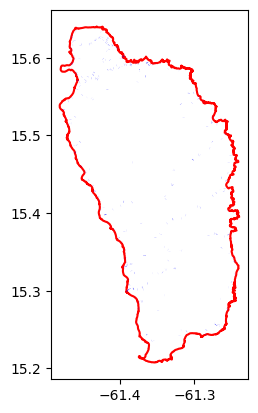

In [27]:
# Plot the area and buildings for visualization

fig, ax = plt.subplots()
area_of_interest.boundary.plot(ax=ax, color="red")
bridges.plot(ax=ax, color="blue", alpha=0.7)
plt.show()